In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from embeddings import *
from models import *
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [14]:
RANDOM_SEED = 1
DATA_FOLDER = "twitter-datasets/"
TRAIN_NEG_FILE = DATA_FOLDER + "train_neg.txt"
TRAIN_POS_FILE = DATA_FOLDER + "train_pos.txt"

In [15]:
def create_dataset(neg_tweets_file, pos_tweets_file):
    tweets = []
    labels = []
    with open(neg_tweets_file, "r", encoding="utf-8") as f:
        for line in f:
            tweets.append(line.rstrip())
            labels.append(-1)
    with open(pos_tweets_file, "r", encoding="utf-8") as f:
        for line in f:
            tweets.append(line.rstrip())
            labels.append(1)
    df = pd.DataFrame({"tweet": tweets, "label": labels})
    df = df.drop_duplicates(subset=["tweet", "label"])
    return df

def split_dataset(dataset, test_fraction, seed=RANDOM_SEED):
    shuffled_dataset = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df, test_df = train_test_split(shuffled_dataset, test_size=test_fraction, random_state=seed)
    return train_df, test_df

def get_data(embedding):
    print("Preparing data...")
    dataset = create_dataset(TRAIN_NEG_FILE, TRAIN_POS_FILE)
    train_data, test_data = split_dataset(dataset, 0.1, seed=RANDOM_SEED)
    train_labels = train_data["label"].to_numpy()
    test_labels = test_data["label"].to_numpy()

    print("Getting embedding...")
    embedding.fit(train_data["tweet"].to_numpy())
    train_tweets = embedding.encode(train_data["tweet"].to_numpy(), "train_tweets")
    test_tweets = embedding.encode(test_data["tweet"].to_numpy(), "test_tweets")

    return train_tweets, train_labels, test_tweets, test_labels

In [16]:
def evaluate_accuracy(predicted, actual):
    assert predicted.shape == actual.shape
    return (predicted == actual).mean()

In [17]:
def make_learning_curves(model, train_tweets, train_labels, test_tweets, test_labels, title):
    training_size_max = train_tweets.shape[0]
    num_steps = 5
    step_size = int(train_tweets.shape[0] / num_steps)
    training_size_min = step_size
    dataset_sizes = np.arange(training_size_min, training_size_max, step_size)

    train_accuracy = []
    test_accuracy = []

    for train_size in tqdm(dataset_sizes, desc=f"Making learning curves..."):
        model.train(train_tweets[:train_size], train_labels[:train_size])
        train_pred = model.predict(train_tweets)
        test_pred = model.predict(test_tweets)
        train_accuracy.append(evaluate_accuracy(train_pred, train_labels))
        test_accuracy.append(evaluate_accuracy(test_pred, test_labels))

    plot_learning_curves(train_accuracy, test_accuracy, dataset_sizes, title)


def plot_learning_curves(train_accuracy, test_accuracy, dataset_sizes, title):
    plt.figure()
    plt.plot(dataset_sizes, train_accuracy, 'r--', label="Training Accuracy")
    plt.plot(dataset_sizes, test_accuracy, 'b-', label="Test Accuracy")
    plt.ylim([0.4, 1])
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.grid(True)
    plt.xlabel("Dataset Size")
    plt.ylabel("Accuracy")
    plt.title(f"{title}")
    plt.legend()
    plt.show()

In [18]:
def evaluate_baseline(embedding, model):
    train_tweets, train_labels, test_tweets, test_labels = get_data(embedding)

    print(f"Training {model} with {embedding}...")
    make_learning_curves(model, train_tweets, train_labels, test_tweets, test_labels, title=f"{model} with {embedding}")
    return evaluate_accuracy(model.predict(test_tweets), test_labels)

Bag of Words baseline:
Preparing data...
Getting embedding...
Training Logistic Regression with Bag of Words (5000)...


Making learning curves...: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


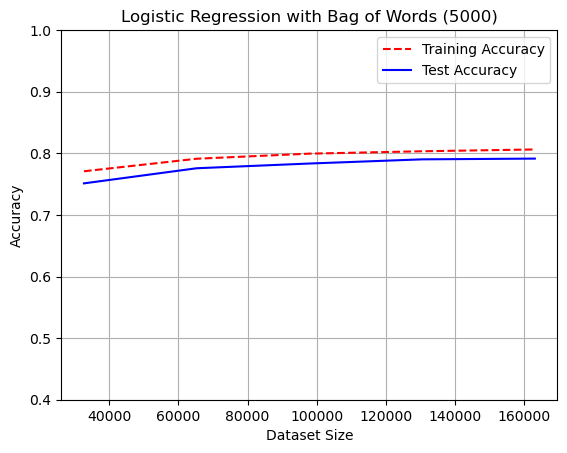

Final accuracy: 0.7914299895218662
Roberta baseline:


C:\Users\Jacqueline\.conda\envs\ml\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing data...
Getting embedding...
Embeddings file not found. Making new embeddings instead.


Encoding train_tweets: 100%|██████████| 163188/163188 [25:36<00:00, 106.18it/s]


Embeddings file not found. Making new embeddings instead.


Encoding test_tweets: 100%|██████████| 18133/18133 [02:53<00:00, 104.67it/s]


Training Logistic Regression with Roberta Base Sentiment...


Making learning curves...: 100%|██████████| 5/5 [03:10<00:00, 38.16s/it]


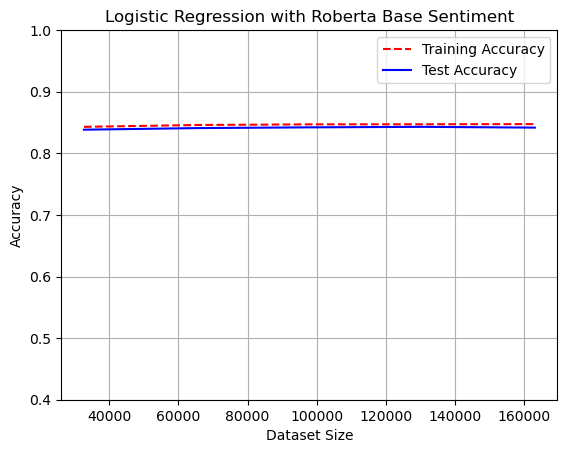

Final accuracy: 0.8417250317101417


In [19]:
np.random.seed(RANDOM_SEED)

print("Bag of Words baseline:")
embedding = BagOfWords()
model = LogisticRegression()
final_accuracy = evaluate_baseline(embedding, model)
print(f"Final accuracy: {final_accuracy}")

print("Roberta baseline:")
embedding = RobertaBaseSentimentEmbedding(load_embeddings=True)
model = LogisticRegression()
final_accuracy = evaluate_baseline(embedding, model)
print(f"Final accuracy: {final_accuracy}")